In [41]:
import numpy as np 
import pandas as pd 
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [154]:
#import keras
from keras.layers import Dense
from keras.models import Sequential
#from keras.layers import LSTM


ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [24]:
df=pd.read_pickle("../Data/filteredDataAQ.pkl") 
df.head() 

,PM25,PM10,CO,NO2,O3,NH3,SO2,TEMPRATURE,ALTITUDE,HUMIDITY,AQI,Year,Month,Day,Hour,Weekday
dt,,,,,,,,,,,,,,,,
2020-01-12 00:00:00,198.64,544.83,2.12,10.60,2.49,20.30,1.87,13.67,185,65,363.22,2020,1,12,0,6
2020-01-12 00:15:00,197.78,526.72,2.25,10.92,2.47,20.33,2.81,13.63,187,59,351.15,2020,1,12,0,6
2020-01-12 00:30:00,192.20,409.04,2.22,11.50,2.42,20.22,2.52,13.40,188,64,272.69,2020,1,12,0,6
2020-01-12 00:45:00,192.20,409.04,2.06,11.08,2.33,20.76,2.41,13.44,195,64,272.69,2020,1,12,0,6
2020-01-12 01:00:00,192.20,409.04,1.93,10.43,2.29,19.59,2.40,13.51,190,60,272.69,2020,1,12,1,6


In [ ]:

# # mark all NA values with 0
# df['AQI'].fillna(0, inplace=True)
# df.head

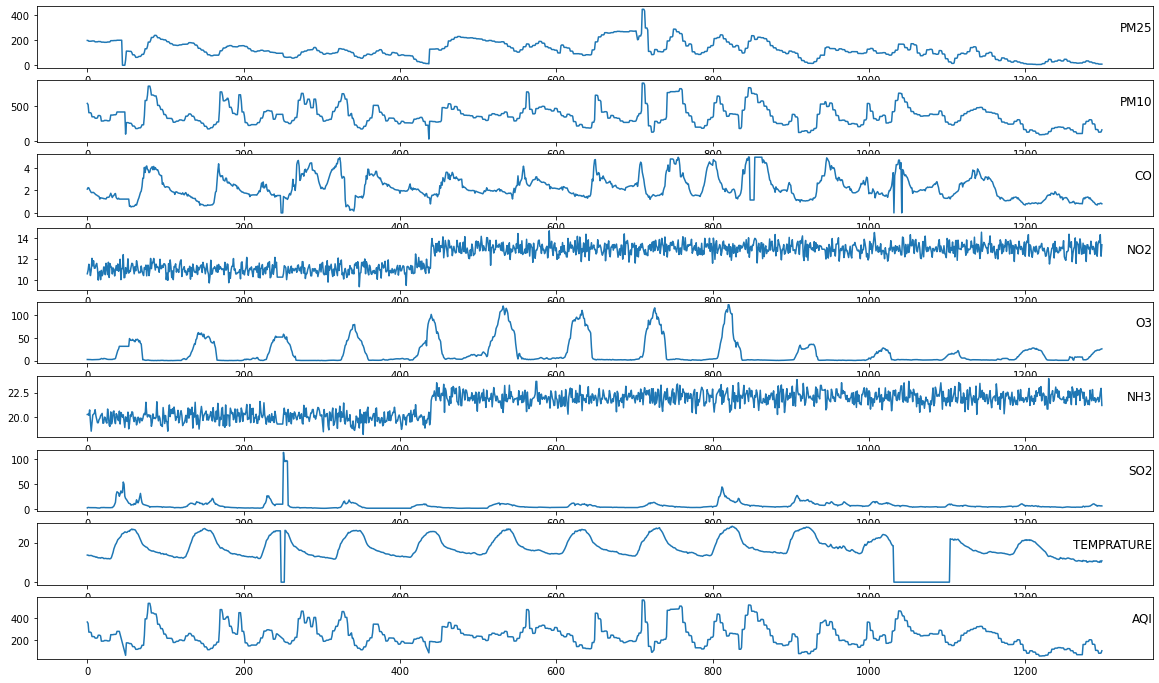

In [14]:
groups = ['PM25', 'PM10', 'CO', 'NO2', 'O3', 'NH3', 'SO2', 'TEMPRATURE', 'AQI']
i = 1
# plot each column
plt.figure()
for group in groups:
    fig = plt.gcf()
    fig.set_size_inches(20, 12)
    plt.subplot(len(groups), 1, i)
    plt.plot(df[group])
    plt.title(group, y=0.5, loc='right')
    i += 1
plt.show()

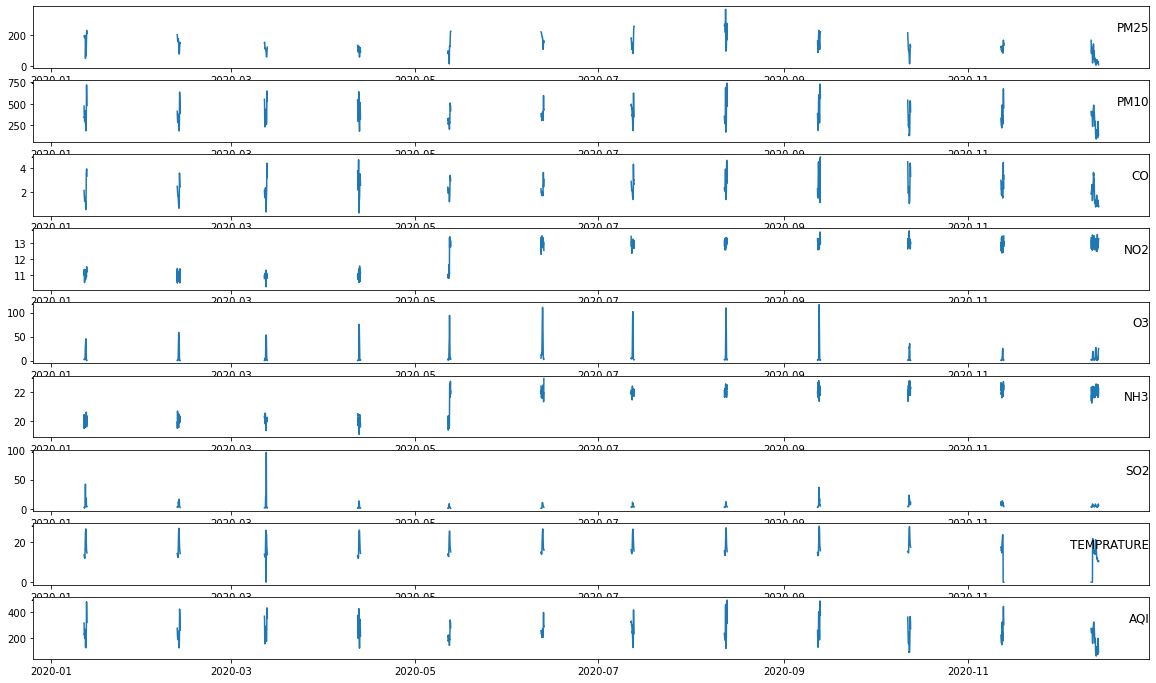

In [22]:
groups = ['PM25', 'PM10', 'CO', 'NO2', 'O3', 'NH3', 'SO2', 'TEMPRATURE', 'AQI']


i = 1
# plot each column
plt.figure()
for group in groups:
    fig = plt.gcf()
    fig.set_size_inches(20, 12)
    plt.subplot(len(groups), 1, i)
    plt.plot(df[group].resample("H").mean())
    plt.title(group, y=0.5, loc='right')
    i += 1
plt.show()

### Time windowing dataset
**Series to supervised learning**

In [63]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
     cols.append(df.shift(i))
     names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
     cols.append(df.shift(-i))
     if i == 0:
         names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
     else:
         names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = pd.concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
     agg.dropna(inplace=True)
 return agg

In [37]:
n_steps_in=1
n_steps_out=1

In [145]:
## resampling of data over hour
df_resample = df.resample('h').mean() 
K=df_resample.isna().sum(axis=1)>3
l=[]
for i in df_resample.index:
    if K[i]==True:
        l.append(i)
df_resample=df_resample.drop(l)

In [146]:
values = df_resample.values 

# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_steps_in, n_steps_out)

# drop columns we don't want to predict
reframed.drop(reframed.columns[16:26].append(reframed.columns[27:]), axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1   0.519928   0.588354   0.401284   0.212402   0.020073   0.345679   
2   0.514852   0.442266   0.333333   0.258019   0.017175   0.106563   
3   0.507228   0.382634   0.306581   0.312188   0.018077   0.350877   
4   0.502063   0.399299   0.263242   0.162509   0.019429   0.147498   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
0        NaN        NaN        NaN         NaN         NaN         NaN   
1   0.014069   0.484474   0.310345    0.285714    0.588352         0.0   
2   0.014279   0.478926   0.448275    0.428571    0.442267         0.0   
3   0.013651   0.459508   0.551723    0.448979    0.382632         0.0   
4   0.007035   0.445011   0.206896    0.244898    0.399297         0.0   

   var13(t-1)  var14(t-1)  var15(t-1)  var16(t-1)  var11(t)  
0         NaN         NaN         NaN         NaN  0.588352  
1   

In [149]:
# split into train and test sets
values = reframed.values
n_train_hours = 10 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_Y = train[:, :-n_steps_out], train[:, -n_steps_out:]
test_X, test_Y = test[:, :-n_steps_out], test[:, -n_steps_out:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps_in, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], n_steps_in, test_X.shape[1]))
#train_Y = train_Y.reshape((train_X.shape[0], n_steps_in, train_X.shape[1]))
#test_Y = test_Y.reshape((test_X.shape[0], n_steps_in, test_X.shape[1]))

print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(240, 1, 16) (240, 1) (85, 1, 16) (85, 1)


In [150]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_Y, epochs=50, batch_size=72, validation_data=(test_X, test_Y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: name 'Sequential' is not defined

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_Y = test_Y.reshape((len(test_Y), 1))
inv_y = concatenate((test_Y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# Serialize mlp_nn object into a file called mlp_nn.pkg on disk using pickle
with open('lstmModel.pkl', 'wb') as handle:
    pickle.dump(model, handle, pickle.HIGHEST_PROTOCOL)
    

In [ ]:
# de-serialize mlp_nn.pkl file into an object called mlp_nn using pickle
with open('lstmModel.pkl', 'rb') as handle:
    lstmModel = pickle.load(handle) 